In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time

In [2]:
Omega_x = np.array([[0, 0, 0], [0, 0, -1], [0, 1, 0]], dtype=float)
Omega_y = np.array([[0, 0, 1], [0, 0, 0], [-1, 0, 0]], dtype=float)
Omega_z = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 0]], dtype=float)
Identity = np.identity(3)

In [3]:
# Function to calculate the propagator
def calc_U_k(omega, theta, A, dt):
    H_k = omega*Omega_z + A*np.cos(theta)*Omega_x + A*np.sin(theta)*Omega_y
    U_k = expm(dt * H_k)
    return U_k

In [4]:
def sim_forward(initial_state, omegas, thetas, A, dt):
    n_steps = len(thetas)
    n_omegas = len(omegas)
    state_history = np.zeros((n_omegas, n_steps + 1, 3))
    U_k_history = np.zeros((n_omegas, n_steps, 3, 3), dtype=complex)
    state_history[:, 0, :] = initial_state

    current_states = np.tile(initial_state, (n_omegas, 1)).astype(complex)

    for j in range(n_steps):
        U_k_j = np.array([calc_U_k(omega, thetas[j], A, dt) for omega in omegas])
        U_k_history[:, j, :, :] = U_k_j

        current_states = np.einsum('oij,oj->oi', U_k_j, current_states)
        state_history[:, j + 1, :] = current_states

    return np.real(state_history), U_k_history

In [5]:
def sim_backward(target_state, U_k_history):

    n_omegas, n_steps = U_k_history.shape[:2]
    back_states = np.zeros((n_omegas, n_steps + 1, 3), dtype=complex)
    back_states[:, n_steps, :] = target_state

    current_back_states = np.tile(target_state, (n_omegas, 1)).astype(complex) 

    for j in range(n_steps - 1, -1, -1):

        U_k_trans = U_k_history[:, j, :, :].transpose(0, 2, 1).conj()
        current_back_states = np.einsum('oij,oj->oi', U_k_trans, current_back_states)
        back_states[:, j, :] = np.real(current_back_states)
    return np.real(back_states) 

In [6]:
def calc_cost(final_states, target_state):

    cost = np.dot(final_states, target_state)
    return np.mean(cost)

In [7]:
def optimise_theta_k(Xk_minus1, Yk_plus1):

    products = np.cross(Xk_minus1, Yk_plus1, axisa=1, axisb=1)

    E = np.sum(products, axis=0)
    E1 = E[0]
    E2 = E[1]

    optimal_theta = np.arctan2(E2, E1)

    return optimal_theta

In [8]:
def optimise_sequential(initial_thetas, target_state, initial_state, omegas, A, dt, iterations, cost_threshold):
   
    thetas = np.copy(initial_thetas)
    n_steps = len(thetas)
    n_omegas = len(omegas)
    cost_history = []

    print(f"Starting TOPS-1 Sequential Optimization...")
    print(f"Parameters: n_steps={n_steps}, A={A:.2f} rad/s, dt={dt:.6f} s, N_omegas={n_omegas}")
    print(f"Target state: {target_state}, Initial state: {initial_state}")

    start_time = time.time()

    for iteration in range(iterations):

        state_history, U_k_history = sim_forward(initial_state, omegas, thetas, A, dt)
        final_states = state_history[:, -1, :]

        current_cost = calc_cost(final_states, target_state)
        cost_history.append(current_cost)

        if iteration % 10 == 0 or iteration == iterations - 1:
            print(f"Iteration {iteration}/{iterations}, Cost: {current_cost:.6f}")

        if current_cost >= cost_threshold:
            print(f"Target cost threshold reached at iteration {iteration}.")
            break

        back_states = sim_backward(target_state, U_k_history)

        for j in range(n_steps):
            Xk_minus1 = state_history[:, j, :]
            Yk_plus1 = back_states[:, j + 1, :]

            thetas[j] = optimise_theta_k(Xk_minus1, Yk_plus1)

    else:
        print(f"Maximum iterations reached without reaching target cost.")

    end_time = time.time()
    print(f"Optimization completed in {end_time - start_time:.2f} seconds.")
    print(f"Final cost: {current_cost:.6f}")

    return thetas, cost_history

In [9]:
def plot_results(thetas, T, n_steps, A, initial_state, omegas, cost_history, pulse_type):
    """Generates and saves plots similar to the notebook style."""
    print("Generating plots...")
    dt = T / n_steps

    # Simulate final magnetization profile
    final_states_sim, _ = sim_forward(initial_state, omegas, thetas, A, dt)
    final_mx = final_states_sim[:, -1, 0]
    final_my = final_states_sim[:, -1, 1]
    final_mz = final_states_sim[:, -1, 2]

    time_points_s = np.linspace(0, T, n_steps + 1)[1:] # Time points for phases

    # --- Plotting ---
    # plt.style.use('seaborn-v0_8-darkgrid') # Optional: Use seaborn style if available

    # 1. Cost Function Profile

    plt.figure(figsize=(6, 5))
    plt.plot(cost_history, label=f'TOPS-1 {pulse_type}')
    plt.title(f'{pulse_type} Cost Function (Fidelity)')
    plt.xlabel('Iteration')
    plt.ylabel('Fidelity (J)')
    plt.ylim(bottom=min(-0.2, np.min(cost_history) if cost_history else -0.2)) # Adjust y-min
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'tops1_{pulse_type.lower()}_cost.png')
    plt.show() # Show plot
    plt.close() # Close plot


    # 2. Final Magnetization Profile
    plt.figure(figsize=(8, 5))
    if pulse_type == 'Inversion':
        plt.plot(omegas, final_mz, label='TOPS-1 (Mz)')
        plt.ylabel('z component magnetization')
        plt.ylim([-1.1, 1.1])
    else: # Excitation
        plt.plot(omegas, final_mx, label='TOPS-1 (Mx)')
        # plt.plot(omegas_rad_s, final_my, label='TOPS-1 (My)', linestyle='--') # Optional
        plt.ylabel('x component magnetization')
        plt.ylim([-1.1, 1.1])

    plt.title(f'{pulse_type} Profile')
    plt.xlabel('Bandwidth (rad/s)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'tops1_{pulse_type.lower()}_profile.png')
    plt.show() # Show plot
    plt.close()


    # 3. Phase Profile
    plt.figure(figsize=(8, 5))
    # Use unwrap for continuous view, convert to degrees
    plt.plot(time_points_s, (np.degrees(np.unwrap(thetas))%360), label='TOPS-1')
    plt.title(f'{pulse_type} Phase Profile')
    plt.xlabel('Time (s)')
    plt.ylabel('Phase (degrees)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'tops1_{pulse_type.lower()}_phase.png')
    plt.show()
    plt.close()

    print(f"Saved {pulse_type} plots.")

def save_thetas(thetas, filename="tops1_thetas.txt"):
    """Saves the optimized phases to a text file."""
    np.savetxt(filename, thetas, fmt='%.8f', header='Optimized Phases (radians)')
    print(f"Saved optimized phases to {filename}")


------------------------------
--- Designing Inversion Pulse ---
Starting TOPS-1 Sequential Optimization...
Parameters: n_steps=400, A=1.00 rad/s, dt=0.157080 s, N_omegas=400
Target state: [ 0.  0. -1.], Initial state: [0. 0. 1.]


/var/folders/hc/306phn6j0gj3538z1msbnzh00000gn/T/ipykernel_42754/2471737496.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  state_history[:, j + 1, :] = current_states


Iteration 0/500, Cost: -0.621440
Iteration 10/500, Cost: 0.129528
Iteration 20/500, Cost: -0.126396
Iteration 30/500, Cost: 0.112372
Iteration 40/500, Cost: 0.158502
Iteration 50/500, Cost: -0.053795
Iteration 60/500, Cost: 0.086740
Iteration 70/500, Cost: -0.059036
Iteration 80/500, Cost: 0.094094
Iteration 90/500, Cost: 0.097469
Iteration 100/500, Cost: -0.027390
Iteration 110/500, Cost: 0.107010
Iteration 120/500, Cost: -0.079490
Iteration 130/500, Cost: -0.275461
Iteration 140/500, Cost: -0.022589
Iteration 150/500, Cost: -0.000997
Iteration 160/500, Cost: 0.109310
Iteration 170/500, Cost: 0.017041
Iteration 180/500, Cost: 0.017783
Iteration 190/500, Cost: 0.079244
Iteration 200/500, Cost: 0.098350
Iteration 210/500, Cost: -0.140418
Iteration 220/500, Cost: 0.171514
Iteration 230/500, Cost: 0.074816
Iteration 240/500, Cost: -0.094688
Iteration 250/500, Cost: -0.035538
Iteration 260/500, Cost: -0.073391
Iteration 270/500, Cost: 0.245962
Iteration 280/500, Cost: -0.009583
Iteration 2

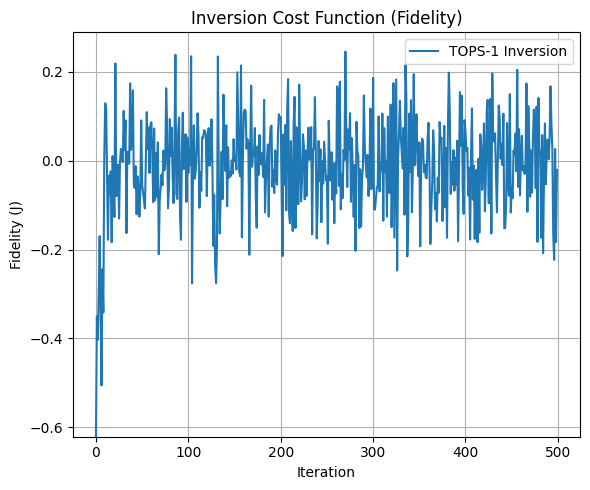

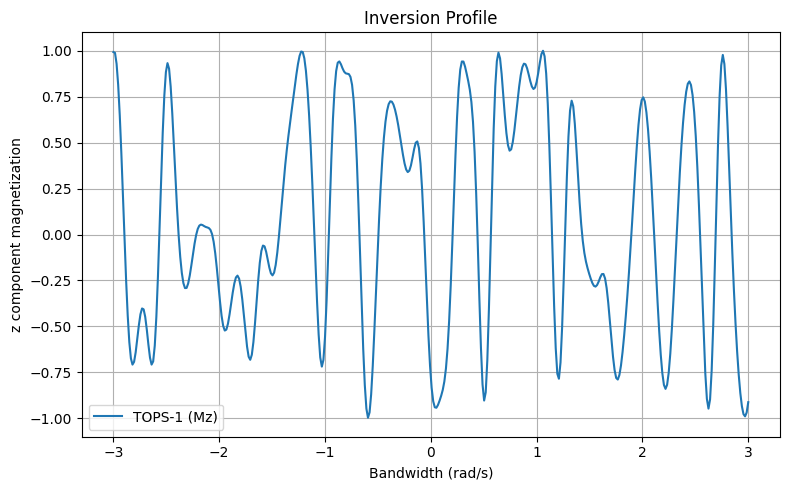

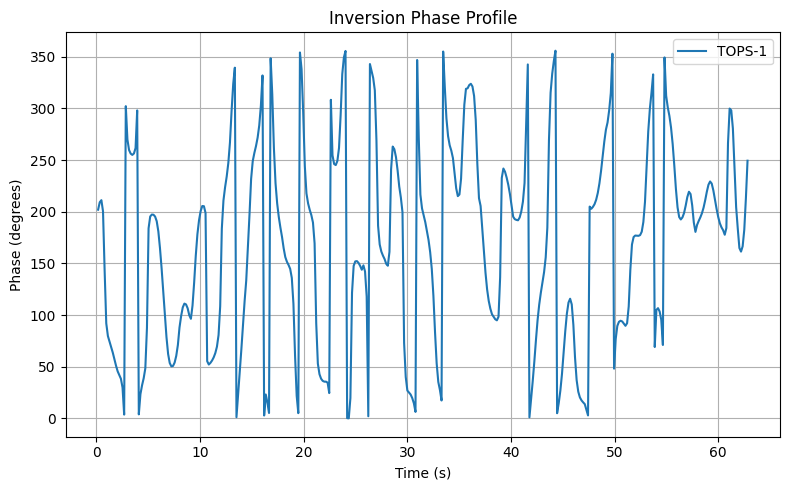

Saved Inversion plots.
Saved optimized phases to tops1_inversion_phases.txt

------------------------------
--- Designing Excitation Pulse ---
Starting TOPS-1 Sequential Optimization...
Parameters: n_steps=400, A=1.00 rad/s, dt=0.157080 s, N_omegas=400
Target state: [1. 0. 0.], Initial state: [0. 0. 1.]
Iteration 0/500, Cost: -0.000000
Iteration 10/500, Cost: -0.036711
Iteration 20/500, Cost: -0.168008
Iteration 30/500, Cost: 0.148471
Iteration 40/500, Cost: -0.100534
Iteration 50/500, Cost: -0.188813
Iteration 60/500, Cost: 0.087251
Iteration 70/500, Cost: -0.118559
Iteration 80/500, Cost: -0.024365
Iteration 90/500, Cost: 0.058598
Iteration 100/500, Cost: 0.157933
Iteration 110/500, Cost: 0.017696
Iteration 120/500, Cost: 0.008455
Iteration 130/500, Cost: 0.014343
Iteration 140/500, Cost: 0.074450
Iteration 150/500, Cost: 0.122245
Iteration 160/500, Cost: 0.080155
Iteration 170/500, Cost: 0.044365
Iteration 180/500, Cost: -0.129886
Iteration 190/500, Cost: -0.111862
Iteration 200/500

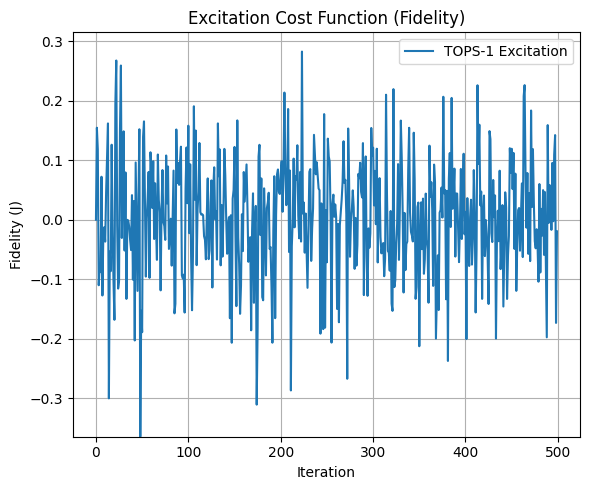

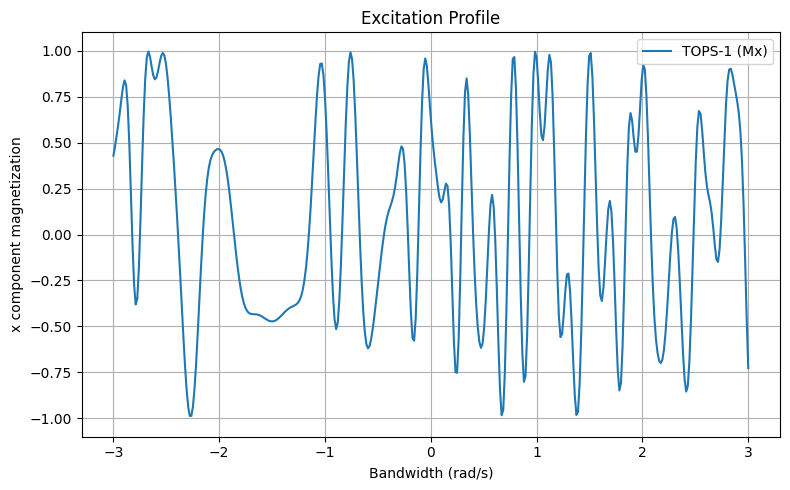

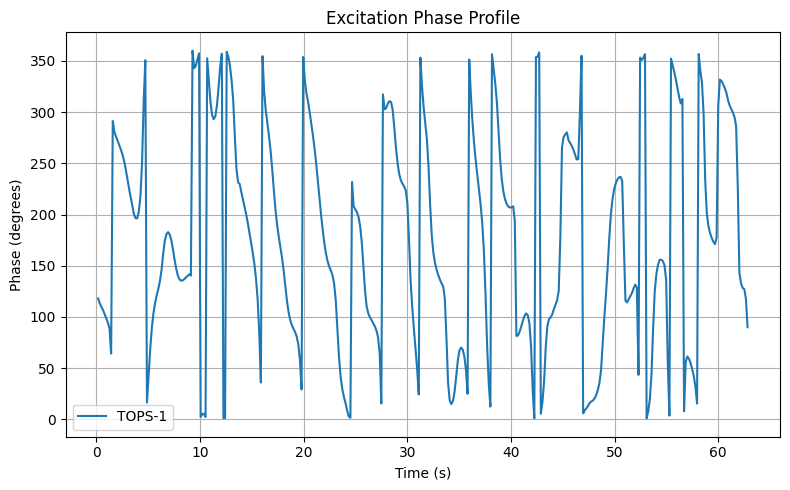

Saved Excitation plots.
Saved optimized phases to tops1_excitation_phases.txt

Finished both optimizations.


In [10]:
if __name__ == "__main__":

    T = 20 * np.pi      # Total pulse duration (s)
    n_steps = 400       # Number of piece-wise constant phases
    dt = T / n_steps    # Time step duration (s)

    A = 1            # RF amplitude (rad/s)
    bandwidth = 6  # Full bandwidth [-3, 3] rad/s
    omegas = np.linspace(-bandwidth / 2, bandwidth / 2, 400) # Offset frequencies
    n_omegas = len(omegas)

    initial_state = np.array([0.0, 0.0, 1.0])

    iterations = 500 # Use fewer iterations for a quicker example run
    cost_threshold = 0.95

    # --- Design 1: Inversion Pulse ---
    print("\n" + "-" * 30)
    print("--- Designing Inversion Pulse ---")
    target_inv = np.array([0.0, 0.0, -1.0]) # Target Mz = -1
    initial_thetas_inv = np.zeros(n_steps) # Initialize phases to 0

    optimised_thetas_inv, cost_history_inv = optimise_sequential(
        initial_thetas_inv, target_inv, initial_state,
        omegas, A, dt, iterations, cost_threshold
    )
    if cost_history_inv: # Check if optimization ran
         plot_results(optimised_thetas_inv, T, n_steps, A, initial_state, omegas, cost_history_inv, "Inversion")
         save_thetas(optimised_thetas_inv, filename="tops1_inversion_phases.txt")


    # --- Design 2: Excitation Pulse ---
    print("\n" + "-" * 30)
    print("--- Designing Excitation Pulse ---")
    target_ex = np.array([1.0, 0.0, 0.0]) # Target Mx = 1
    initial_thetas_exc = np.zeros(n_steps) # Initialize phases to 0

    optimised_thetas_exc, cost_history_exc = optimise_sequential(
        initial_thetas_exc, target_ex, initial_state,
        omegas, A, dt, iterations, cost_threshold
    )
    if cost_history_exc: # Check if optimization ran
        plot_results(optimised_thetas_exc, T, n_steps, A, initial_state, omegas, cost_history_exc, "Excitation")
        save_thetas(optimised_thetas_exc, filename="tops1_excitation_phases.txt")

    print("\nFinished both optimizations.")